In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community --quiet

!pip install arxiv wikipedia --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

In [3]:
## Working With Tools



from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun



## Arxiv And Wikipedia tools

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)

arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)



api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)

wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [4]:
wiki_tool.invoke("who is Mustafa Shoukat")

"Page: Shaukat Siddiqui\nSummary: Shaukat Siddiqi (Urdu: شوکت صدیقی; 20 March 1923 – 18 December 2006) was a Pakistani writer of fiction who wrote in Urdu language. He is best known for his  novels Khuda Ki Basti (God's Village) and Jangloos.\n\n"

In [5]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [6]:
tools=[arxiv_tool]

In [7]:
## Langgraph Application

from langgraph.graph.message import add_messages

class State(TypedDict):

  messages:Annotated[list,add_messages]

In [8]:
from langgraph.graph import StateGraph,START,END

In [9]:
graph_builder= StateGraph(State)


In [10]:
from langchain_groq import ChatGroq

In [11]:
groq_api_key= "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"

In [12]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x794fb836e410>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x794fb839c880>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [13]:
llm_with_tools=llm.bind_tools(tools=tools)

In [14]:
def chatbot(state:State):

  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [15]:
from langgraph.prebuilt import ToolNode,tools_condition

In [16]:
graph_builder.add_node("chatbot",chatbot)

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)



graph_builder.add_conditional_edges(

    "chatbot",

    tools_condition,

)

graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START,"chatbot")


In [17]:
graph=graph_builder.compile()

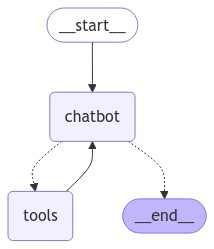

In [18]:
from IPython.display import Image, display



try:

    display(Image(graph.get_graph().draw_mermaid_png()))

except Exception:

    # This requires some extra dependencies and is optional

    pass

In [19]:
user_input="Hi there!, My name is John"



events=graph.stream(

     {"messages": [("user", user_input)]},stream_mode="values"

)



for event in events:

  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_cema)
 Call ID: call_cema
  Args:
    query: John
================================= Tool Message =================================
Name: arxiv

Published: 2014-03-19
Title: Chromatic redshift
Authors: John Rognes
Summary: Notes for the author's MSRI lecture in January 2014.
================================== Ai Message ==================================

Interesting.  What else can I help you with?


In [20]:
user_input = "what is RLHF."



# The config is the **second positional argument** to stream() or invoke()!

events = graph.stream(

    {"messages": [("user", user_input)]},stream_mode="values"

)

for event in events:

    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_zhgv)
 Call ID: call_zhgv
  Args:
    query: RLHF
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-15
Title: Exploration-Driven Policy Optimization in RLHF: Theoretical Insights on Efficient Data Utilization
Authors: Yihan Du, Anna Winnicki, Gal Dalal, Shie Mannor, R. Srikant
Summary: Reinforcement Learning from Human Feedback (RLHF) has achieved impressive
empirical successes 
================================== Ai Message ==================================

RLHF, or Reinforcement Learning from Human Feedback, is a technique used to train AI models by incorporating human feedback into the learning process.  

Here's a breakdown:

* **Reinforcement Learning (RL):**  AI learns by interacting with an environment and receiving 